# Posterior sampling of irregularly sampled ODEs corrupted by noise

In [33]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import diffrax # odes in jax
import distrax # probability distributions in jax
import blackjax # mcmc sampling in jax
import matplotlib.pyplot as plt

We consider the Lotka-Volterra ODE with state $x= [x_1\, x_2]^\top \in \mathbb{R}^{n_x}, n_x=2$:
\begin{align*}
\dot x_1  &= \alpha x - \beta x_1 x_2\\
\dot x_2  &= -\gamma x_2 + \delta x_1 x_2,
\end{align*}

where the parameters $\theta = [\alpha\, \beta\, \gamma\, \delta] \in \mathbb{R}^{n_\theta}, n_{\theta} = 4$, are uncertain. We denote its solution as

\begin{equation*}
x(t) = \mathrm{ODEint}(t, x_0, \theta)
\end{equation*}

We have a dataset of noisy samples from a measured system trajectory, irregularly sampled over time:
\begin{align*}
t &= [t_0\, \dots\, t_{N-1}]^\top \in \mathbb{R}^N\\
\tilde x &= [\tilde x(t_0)\, \dots\, \tilde x(N-1)]^\top \in \mathbb{R}^{N \times n_x}
\end{align*}

We have an initial guess of the parameters $\mu_{\theta} \in \mathbb{R}^{n_\theta}$ and of the standard deviation $\sigma_{\theta} \in \mathbb{R}^{n_\theta}$. 


We compute posterior on the parameters (and initial state) from the probabilistic model:

\begin{align*}
x_0 \sim \mathcal{N}(\mu_{x_0}, \sigma_{x_0})\\
\theta \sim \mathcal{N}(\mu_{\theta}, \sigma_{\theta})\\
x \sim \mathcal{N}(\mathrm{ODEint}(x_0, \theta), \sigma_e).
\end{align*}

* To solve ODEs, we use ``diffrax``
* To compute approximate posterior, we apply the Laplace approximation and use JAX's autodiff to compute the required Hessian matrix

In [34]:
#%matplotlib widget

In [35]:
# data
nx = 2  # number of states
seq_len = 20  # number of samples, sampling time is irregular
sigma_noise = 2.0  # standard deviation of the measurement noise
sigma_theta = 1.0 # standard deviation of the prior on the parameters

In [36]:
theta_true = jnp.array([0.1, 0.02, 0.4, 0.02])
theta_guess = jnp.array([0.12, 0.023, 0.32, 0.03])
sigma_theta = jnp.ones(4,) # a very weak prior

In [37]:
seed = 1234
key = jr.key(seed)
ykey, tkey, noise_key, warmup_key, sample_key = jr.split(key, 5)

In [38]:
# generate 40 irregularly-spaced samples from a Lotka-Volterra ODE system

y0 = 8 * jr.uniform(ykey, (nx,)) + 6

t0 = 0
tf = 140
t_meas = jr.uniform(tkey, (seq_len,)) * (tf - t0) + t0
t_meas = jnp.sort(t_meas)
t_meas = jnp.r_[0.0, t_meas] # add time 0 (nice for plots, not really needed)

t_dense = jnp.linspace(t0, tf, 1_000)
dt0 = 1.0


def vector_field(t, y, args):
    prey, predator = y
    α, β, γ, δ = args
    d_prey = α * prey - β * prey * predator
    d_predator = -γ * predator + δ * prey * predator
    d_y = jnp.array([d_prey, d_predator])
    return d_y


def simulate(params, ts, y0):
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(vector_field),
        diffrax.Tsit5(),
        ts[0],
        ts[-1],
        dt0,
        y0,
        saveat=diffrax.SaveAt(ts=ts),
        stepsize_controller = diffrax.PIDController(rtol=1e-4, atol=1e-4),
        #stepsize_controller=diffrax.ConstantStepSize(),
        adjoint=diffrax.DirectAdjoint(),
        args=params,
    )
    return sol.ys



y_true = simulate(theta_true, t_meas, y0)
y_dense = simulate(theta_true, t_dense, y0)

# just one sequence
t_meas = t_meas
y_true = y_true
y0 = y0
t_meas.shape, y0.shape, y_true.shape


y_meas = y_true + jr.normal(noise_key, y_true.shape) * sigma_noise

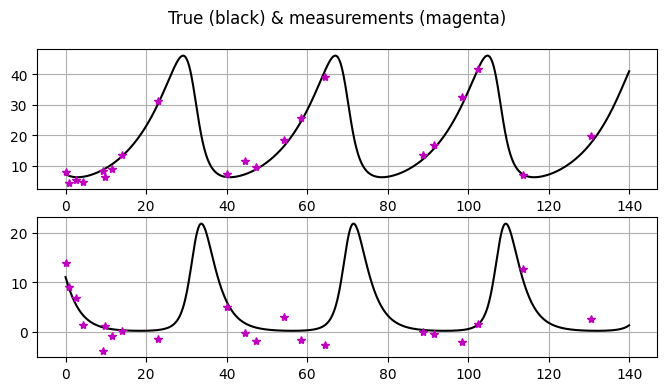

In [39]:
# plot data
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
plt.suptitle("True (black) & measurements (magenta)")
ax[0].plot(t_dense, y_dense[:, 0], "k")
ax[0].plot(t_meas, y_meas[:, 0], "m*")
ax[0].grid()

ax[1].plot(t_dense, y_dense[:, 1], "k")
ax[1].plot(t_meas, y_meas[:, 1], "m*")
ax[1].grid()

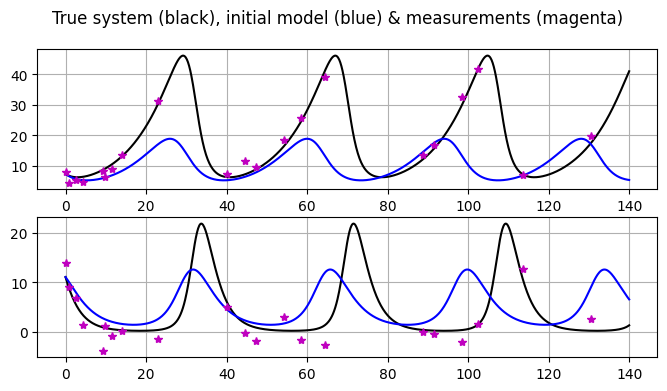

In [40]:
y_init = simulate(theta_guess, t_dense, y0)

# plot data and initial model
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
plt.suptitle("True system (black), initial model (blue) & measurements (magenta)")
ax[0].plot(t_dense, y_dense[:, 0], "k", label="True")
ax[0].plot(t_dense, y_init[:, 0], "b", label="Initial model")
ax[0].plot(t_meas, y_meas[:, 0], "m*", label="Measures")
ax[0].grid(True)
#ax[0].legend()

ax[1].plot(t_dense, y_dense[:, 1], "k")
ax[1].plot(t_dense, y_init[:, 1], "b")
ax[1].plot(t_meas, y_meas[:, 1], "m*")
ax[1].grid(True)

In [41]:
y0 = y_meas[0]
latent_vars = {"theta": jnp.copy(theta_guess), "y0": jnp.copy(y0)}

In [42]:
def log_joint_fn(lv, ts, ys):

    y0 = lv["y0"]
    theta = lv["theta"]
    y_mean = simulate(theta, ts, y0)

    log_prior_par = (
        distrax.Normal(theta_guess, sigma_theta).log_prob(theta).sum()
    )
    log_prior_y0 = distrax.Normal(y0, sigma_noise).log_prob(ys[0]).sum() # for y0, we center a prior around the first observed state

    log_likelihood = distrax.Normal(y_mean[1:], sigma_noise).log_prob(ys[1:]).sum() # first state already accounded in log_prior_y0

    log_joint = log_prior_par + log_prior_y0 + log_likelihood
    return log_joint

In [43]:
potential = jax.jit(partial(log_joint_fn, ts=t_meas, ys=y_meas))
potential(latent_vars)

Array(-370.15656, dtype=float32)

100%|██████████| 1000/1000 [00:03<00:00, 294.35it/s, 88.40051]


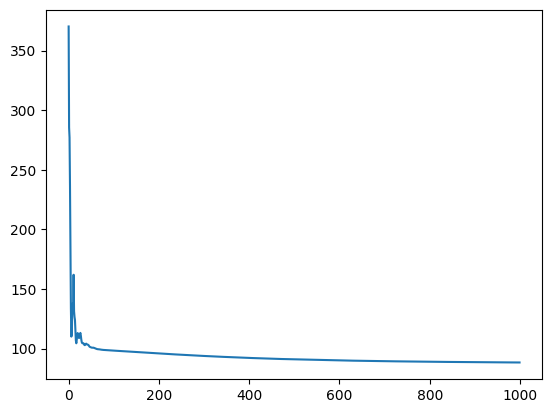

In [44]:
# Find a posterior mode with numerical optimization
from tqdm import tqdm
from flax.training import train_state
import matplotlib.pyplot as plt
import optax 

lr = 2e-3
iters = 1_000
loss_fn_cfg = lambda x : -potential(x)
opt = optax.adamw(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=loss_fn_cfg, params=latent_vars, tx=opt)

@jax.jit
def make_step(state):
    loss, grads = jax.value_and_grad(state.apply_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

LOSS = []
for idx in (pbar := tqdm(range(iters))):
    loss, state = make_step(state)
    LOSS.append(loss.item())
    pbar.set_postfix_str(loss)

latent_vars = state.params

plt.plot(LOSS)

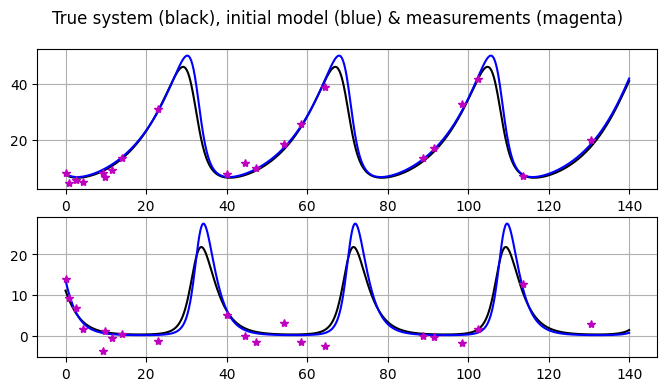

In [45]:
y_opt = simulate(latent_vars["theta"], t_dense, latent_vars["y0"])

# plot data and optimized model
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
plt.suptitle("True system (black), initial model (blue) & measurements (magenta)")
ax[0].plot(t_dense, y_dense[:, 0], "k", label="True")
ax[0].plot(t_dense, y_opt[:, 0], "b", label="Initial model")
ax[0].plot(t_meas, y_meas[:, 0], "m*", label="Measures")
ax[0].grid(True)

ax[1].plot(t_dense, y_dense[:, 1], "k")
ax[1].plot(t_dense, y_opt[:, 1], "b")
ax[1].plot(t_meas, y_meas[:, 1], "m*")
ax[1].grid(True)

In [46]:
latent_flat, unflatten_latent = jax.flatten_util.ravel_pytree(latent_vars)
loss_fn_flat = lambda pf: loss_fn_cfg (unflatten_latent(pf))
loss_fn_flat(latent_flat)
H_gn = jax.hessian(loss_fn_flat)(latent_flat)
P = jnp.linalg.inv(H_gn) #+ jnp.eye(6)*1e-2

In [47]:
def sim_flat(latent_flat):
    latent = unflatten_latent(latent_flat)
    theta = latent["theta"]
    y0 = latent["y0"]
    return simulate(theta, t_meas, y0).ravel()



J = jax.jacobian(sim_flat)(latent_flat)
H_gn = J.T @ J/(sigma_noise**2) + jnp.diag(jnp.concatenate((sigma_theta, jnp.array([0.0, 0.0]))))
#J.shape
P = jnp.linalg.inv(H_gn)

In [48]:
num_steps = 400
latent_flat_samples = jr.multivariate_normal(sample_key, mean=latent_flat, cov=P, shape=(num_steps,))
latent_samples = jax.vmap(unflatten_latent)(latent_flat_samples)

In [49]:
y_pred = jax.vmap(simulate, in_axes=(0, None, 0))(latent_samples["theta"], t_dense, latent_samples["y0"])
y_pred.shape

(400, 1000, 2)

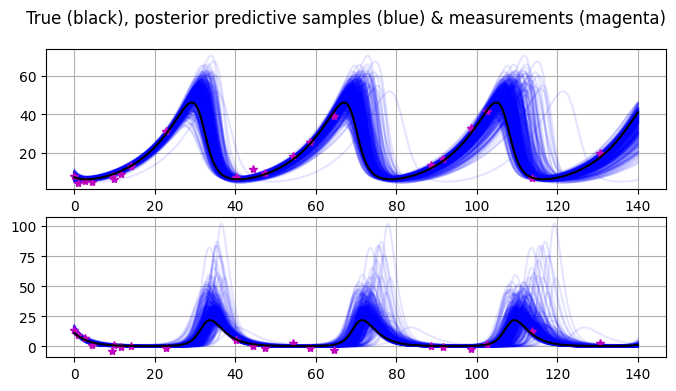

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
plt.suptitle("True (black), posterior predictive samples (blue) & measurements (magenta)")
ax[0].plot(t_dense, y_pred[:, :, 0].T, "b", alpha=0.1)
ax[0].plot(t_meas, y_meas[:, 0], "m*")
ax[0].plot(t_dense, y_dense[:, 0], "k")
ax[0].grid(True)

ax[1].plot(t_dense, y_pred[:, :, 1].T, "b", alpha=0.1)
ax[1].plot(t_meas, y_meas[:, 1], "m*")
ax[1].plot(t_dense, y_dense[:, 1], "k")
ax[1].grid(True)